# Enhance Medical Assistant chatbot with RAG integration

In this lab, I’m improving the performance of the fine-tuned LLM-based Medical Assistant chatbot (https://github.com/diyorarti/medical-assistant) by integrating a Retriever-Augmented Generation (RAG) pipeline. The system leverages three external medical books as the knowledge base to provide more accurate, context-aware, and evidence-based responses.


# Data Loader 1
### Implement data loading pipeline for medical knowledge sources

Developed a data loader to process all PDF files from a folder, extracting text page by page and attaching relevant metadata. The data is loaded using `LangChain.document_loaders.PyPDFLoader`, which treats each page of a PDF as a separate Document object containing both `metadata` and `page_content`.

DATA SOURCES:
1. "Aging: Natural or Disease?" by Alex Zhavoronkov (https://www.ncbi.nlm.nih.gov/books/NBK561517/)
2. "Basic Epidemiology" by R. Bonita, R. Beaglehole, and T. Kjellström (https://iris.who.int/items/3d726576-7d68-4e66-a18b-25abf77c4894)
3. "Genes and Disease" by NCBI (https://www.ncbi.nlm.nih.gov/books/NBK22183/)

Utility-1

In [1]:
import hashlib
from pathlib import Path

def sha256_file(path:Path, chunk_size:int=8192)->str:
    """
    Comupute file Fingerprint
    helps to track whether a file's content has changed or avoid reprocessing duplicates
    """
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

In [3]:
from pathlib import Path
from typing import List
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document

def load_data(data_dir:str, min_chars: int = 30) -> List[Document]:
    """
    Recursively load PDFs under `data_dir` and return page-level documents
    enriched with stable file metadata (absolute path, source path, mtime, sha256)

    Args:
        data_dir:Root directory to scan for PDFs
        min_chars:Minimum non-whitespace charaters to keep a page
    """
    data_dir = Path(data_dir)
    files = list(data_dir.glob("**/*.pdf"))
    print(f"Number of files {len(files)}")
    all_documents: List[Document] = []
    skipped_pages = 0

    for file in files:
        abs_path = file.resolve()
        print(f"Processing file: {abs_path}")

        try:
            loader = PyPDFLoader(str(abs_path))
            documents = loader.load()
        except Exception as e:
            print(f"!! Skipping {abs_path} due to error: {e}")
            continue

        file_hash = sha256_file(abs_path)
        try:
            mtime = abs_path.stat().st_mtime
        except Exception:
            mtime = None

        for doc in documents:
            content = (doc.page_content or "").strip()
            if len(content) < min_chars:
                skipped_pages += 1
                continue
            meta = dict(doc.metadata or {})
            page = meta.get("page")
            meta.update({
                "source":str(abs_path),
                "source_file":str(abs_path),
                "source_name":abs_path.name,
                "file_type":"pdf",
                "file_sha256":file_hash,
                "file_mtime":mtime,
                "page":page if page is not None else None,
            })
            doc.metadata=meta
        all_documents.extend(documents)
    print(f"skipped (short/blank) so far: {skipped_pages}")
    print(f"\nTotal documents loaded: {len(all_documents)}")
    return all_documents

In [4]:
documents = load_data("../data")

Number of files 3
Processing file: D:\Users\User\RAG-API\data\Aging_natural_or_disease.pdf
Processing file: D:\Users\User\RAG-API\data\basic_epidemiology.pdf
Processing file: D:\Users\User\RAG-API\data\Genes_and_Disease.pdf
skipped (short/blank) so far: 81

Total documents loaded: 466


In [6]:
documents[4].metadata

{'producer': 'Antenna House PDF Output Library 6.6.1477 (Linux64)',
 'creator': 'AH XSL Formatter V6.6 MR7 for Linux64 : 6.6.9.39847 (2019-07-29T09:58+09)',
 'creationdate': '2020-09-03T09:54:06-05:00',
 'moddate': '2020-09-03T09:54:06-05:00',
 'title': 'Aging: natural or disease? A view from medical textbooks',
 'trapped': '/False',
 'source': 'D:\\Users\\User\\RAG-API\\data\\Aging_natural_or_disease.pdf',
 'total_pages': 19,
 'page': 4,
 'page_label': '5',
 'source_file': 'D:\\Users\\User\\RAG-API\\data\\Aging_natural_or_disease.pdf',
 'source_name': 'Aging_natural_or_disease.pdf',
 'file_type': 'pdf',
 'file_sha256': 'f700a35f9fd7ef679f1c72a53b46a46adad1c2273dad8c7d40aeb97c543bb921',
 'file_mtime': 1760668682.7098148}

In [8]:
print(documents[4].page_content)

Table 1. Selected quotations arguing against the aging vs. disease dichotomy.
Charcot, 1881, p. 
2043
“The textural changes which old age induce in the organism sometimes attain such a point that the 
physiological and pathological states seem to mingle by an imperceptible transition and to be no longer sharply 
distinguishable. ”
Kleemeier, 1965, p. 
5544
“Can the effects of aging per se be distinguished from those of pathology? (…) To attribute to aging all time 
associated changes to which no specific cause can be found is at best a temporary holding tactic which will 
suffice only as long as we are ignorant of the mechanism involved. Time alone causes nothing. ”
Hall, 1984, p. 78f45 “ Attempts have been made by numerous workers to separate physiological from pathological aging. The two 
are, however, so interrelated as to make attempts relatively abortive. It would be far more relevant to accept the 
existence of a continuum of ageing phenomena. ”
Rattan, 1991, p. 
52646
“ Although

# CHUNK 2 
### Implement text chunking with RecursiveCharacterTextSplitter

Applied `RecursiveCharacterTextSplitter` for intelligent text chunking.  
Advantages:
1. Provides smart and context-aware splitting  
2. Maintains readability and semantic meaning  
3. Commonly used and highly effective in RAG pipelines


Utility-2

In [10]:
import re

def normalize_text(text: str) -> str:
    """
    clean and normalize raw text extracted from PDFs
    Raw PDF text usually contains:
         broken words due to line breaks
         extra new lines
         inconsistent spacing
    """
    if not text:
        return ""
    text = re.sub(r"(\w)-\s*\n\s*(\w)", r"\1\2", text)
    text = re.sub(r"\s*\n\s*", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

Utility-3

In [15]:
import hashlib 

def get_chunk_id(encoding_name:str="cl100k_base", id_prefix_len:int=16):
    """
    Build two utilities in one go:
        - chunk_id (source_abs, page, chunk_idx, norm_text) -> str
        - tok_len(s) -> int 
    
    Args:
        ebcoding_name: tiktoken endcoding to use (e.g., "cl100k_base").
        id_prefix_len: number of hex chars to keep from the sha256 digest.
    
    return:
        (chunk_id, tok_len, using_tokenizer)
        chunk_id:callable
        tok_le:callable
        using_tokenizer:bool
    """
    enc = None
    try:
        import tiktoken 
        enc = tiktoken.get_encoding(encoding_name)
        def tok_len(s:str) -> int:
            return len(enc.encode(s or ""))
        using_tokenizer = True
    except Exception:
        def tok_len(s:str) -> int:
            return len(s or "")
        using_tokenizer = False

    def chunk_id(source_abs:str, page:int, chunk_idx:int, norm_text:str) -> str:
        base = f"{source_abs}|{page}|{chunk_idx}|{norm_text}"
        return hashlib.sha256(base.encode("utf-8")).hexdigest()[:id_prefix_len]
    return chunk_id, tok_len, using_tokenizer

In [17]:
import hashlib
from pathlib import Path
from typing import List, Tuple, Callable

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

def chunk_document(
        documents:List[Document],
        chunk_size:int=1000,
        chunk_overlap:int=120,
        min_chunk_chars:int=80,
        *,
        encoding_name:str="cl100k_base",
        id_prefix_len:int=12
    ) -> List[Document]:
    """
    split page-level documents into chunk-level documet with stable metadata.
    expects each input Document to represent one page (PuPDFLoader behavior)
    """
    chunk_id, tok_len, using_tok = get_chunk_id(
        encoding_name=encoding_name,
        id_prefix_len=id_prefix_len
    )

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=tok_len,
        separators=["\n\n", "\n", " ", ""],
        keep_separator=False,
    )

    split_docs:List[Document] = []
    seen_within_page = {}

    for d in documents:
        meta = dict(d.metadata or {})
        src_abs = str(Path(meta.get("source_file") or meta.get("source") or "").resolve())
        page = int(meta.get("page")) if meta.get("page") is not None else -1 

        parts = text_splitter.split_text(d.page_content or "")
        running = 0

        seen = seen_within_page.setdefault((src_abs, page), set())

        for idx, raw in enumerate(parts):
            raw_stripped = (raw or "").strip()
            if len(raw_stripped) < min_chunk_chars:
                continue
            norm = normalize_text(raw_stripped)
            if not norm or len(norm) < min_chunk_chars:
                continue
            sig = hashlib.sha256(norm.encode("utf-8")).hexdigest()
            if sig in seen:
                continue
            seen.add(sig)

            child_meta = {
                **meta,
                "source": src_abs,
                "source_file": src_abs,
                "source_name": Path(src_abs).name,
                "page": page,
                "chunk_index": idx,
                "char_start_hint": running,
                "char_end_hint": running + len(raw_stripped),
                "chunk_size": chunk_size,
                "chunk_overlap": chunk_overlap,
                "chunk_id": chunk_id(src_abs, page, idx, norm),
            }

            running += len(raw_stripped)
            split_docs.append(Document(page_content=norm, metadata=child_meta))
    
    print(
        f"Split {len(documents)} page-docs into {len(split_docs)} chunks "
        f"(tokenizer={'tiktoken' if using_tok else 'chars'})"
    )
    return split_docs

In [18]:
chunks = chunk_document(documents)


Split 466 page-docs into 383 chunks (tokenizer=tiktoken)


In [19]:
print(chunks[0].page_content) 
print(chunks[0].metadata)


NLM Citation: Janac S, Clarke B, Gems D. Aging: natural or disease? A view from medical textbooks. In: Vaiserman AM, editor. Anti-aging Drugs: From Basic Research to Clinical Practice [Select Chapters]. Cambridge (UK): Royal Society of Chemistry; 2017. Chapter 2. Bookshelf URL: https://www.ncbi.nlm.nih.gov/books/ Chapter 2. Aging: natural or disease? A view from medical textbooks Sarah Janac,a Brian Clarke,b and David Gems a Abstract According to medical tradition, aging coincides with illnesses such as cancer, Alzheimer’s disease and cardiovascular disease, yet is itself a ‘normal’ , ‘natural’ and non-pathological process. From this perspective, antiaging drugs are more akin to cosmetics and mind-altering drugs than to treatments in the medical sense. Y et, arguably, this traditional view of aging is incorrect. Senescence manifests as a broad spectrum of deteriorative changes, leading to debilitating and ultimately fatal pathologies. It makes little sense to speak of healthy or normal

average chunk length

In [20]:
lengths = [len(c.page_content) for c in chunks]
print("Average chunk length:", sum(lengths) / len(lengths))


Average chunk length: 2018.1514360313315


how many chunks per file has 

In [21]:
from collections import Counter
counts = Counter(c.metadata["source_name"] for c in chunks)
print(counts.most_common(10))


[('basic_epidemiology.pdf', 219), ('Genes_and_Disease.pdf', 141), ('Aging_natural_or_disease.pdf', 23)]


# Embedding 3
### Add sentence embeddings using Sentence-BERT (all-MiniLM-L6-v2)

Implemented sentence embedding for text chunks using the Sentence-BERT model (`all-MiniLM-L6-v2`).  
Embedding dimension: 384.

In [23]:
from typing import List, Optional
from sentence_transformers import SentenceTransformer
import numpy as np

class Embedder:
    """
    A utility class for generating text embeddings using SentenceTransformers.
    Attributes:
        model_name (str): Name of the SentenceTransformer model to load.
        normalize (bool): Whether to normalize embeddings for cosine similarity.
        batch_size (int): Number of texts to embed in each batch.
        model (Optional[SentenceTransformer]): The loaded embedding model instance.

    Methods:
        generate_embeddings(texts: List[str]) -> np.ndarray:
            Generate embeddings for a list of texts (e.g., document chunks).
        
        generate_embedding(query: str) -> np.ndarray:
            Generate an embedding for a single text (e.g., user query).
    """

    def __init__(self, 
                 model_name:str="all-MiniLM-L6-v2",
                 normalize:bool=True,
                 batch_size:int=64,
                 device:Optional[str]=None,
                ):
        self.model_name=model_name
        self.normalize=normalize
        self.batch_size=batch_size
        self.model:Optional[SentenceTransformer]=None
        self._initialize_model()
    
    def _initialize_model(self):
        print(f"Loading Embedding Model: {self.model_name}")
        self.model=SentenceTransformer(self.model_name)
        dim = self.model.get_sentence_embedding_dimension()
        print(f"Model loaded. EMbedding dimension: {dim}")
    
    def generate_embeddings(self, texts:List[str]) -> np.ndarray:
        """Embedding funtion for external knowledge"""
        if self.model is None:
            raise ValueError("embeddding model is not initialized")
        if texts is None or len(texts) == 0:
            dim = self.model.get_sentence_embedding_dimension()
            return np.empty((0, dim), dtype=np.float32)
        print(f"Generating embedding for {len(texts)} texts")
        embs = self.model.encode(
            texts, 
            batch_size=self.batch_size,
            show_progress_bar=True,
            normalize_embeddings=self.normalize,
            convert_to_numpy=True
        ).astype(np.float32, copy=False)
        print(f"Generated emebddings with shape {embs.shape}")
        return embs
    
    def generate_embedding(self, query:str) -> np.ndarray:
        """embedding functionf for single text (queyr)"""
        if self.model is None:
            raise ValueError("Embedding model is not initialized")
        if query is None or query.strip() == "":
            dim = self.model.get_sentence_embedding_dimension()
            return np.zeros((dim, ), dtype=np.float32)
        emb = self.model.encode(
            query,
            show_progress_bar=False,
            normalize_embeddings=self.normalize,
            convert_to_numpy=True
        ).astype(np.float32, copy=False)
        print(f"Generated 1 embedding with dim {emb.shape}")
        return emb
        


In [24]:
embedder = Embedder()

Loading Embedding Model: all-MiniLM-L6-v2
Model loaded. EMbedding dimension: 384


### Extracting text (page_content) from chunks for embedding

In [25]:
texts = [chunk.page_content for chunk in chunks]
metadatas = [ch.metadata for ch in chunks]

# Unique Vector ID generator
### Add unique vector ID generation for each text chunk

Implemented unique ID assignment for every chunk to prevent:
1. Duplicate entries in the database  
2. Re-indexing of identical data  
3. Debugging and traceability issues


In [26]:
def make_vector_id(meta: dict) -> str:
    file_hash = meta.get("file_sha256", "nohash")
    page = meta.get("page", "na")
    chunk_id = meta.get("chunk_id", "")
    return f"{file_hash}:{page}:{chunk_id}"

ids = [make_vector_id(m) for m in metadatas]
assert len(ids) == len(set(ids))


In [27]:
embeddings = embedder.generate_embeddings(texts)
print("Embeddings shape:", embeddings.shape)


Generating embedding for 383 texts


Batches: 100%|██████████| 6/6 [00:29<00:00,  4.93s/it]

Generated emebddings with shape (383, 384)
Embeddings shape: (383, 384)


In [28]:
print(embeddings[0][:10])

[ 0.013672   -0.00695694 -0.02295941  0.05438598  0.05198057  0.02725955
 -0.023275    0.09568653 -0.02938373  0.05685621]


semantic closeness

In [29]:
from numpy import dot
from numpy.linalg import norm

i, j = 0, 1  # compare first two chunks
cos_sim = dot(embeddings[i], embeddings[j]) / (norm(embeddings[i]) * norm(embeddings[j]))
print(f"Cosine similarity between chunk {i} and {j}:----> {cos_sim:.3f}")


Cosine similarity between chunk 0 and 1:----> 0.773


NaN or Inf values

In [30]:
import numpy as np

print("Contains NaN:", np.isnan(embeddings).any())
print("Contains Inf:", np.isinf(embeddings).any())


Contains NaN: False
Contains Inf: False


# Visualization of Emebedding

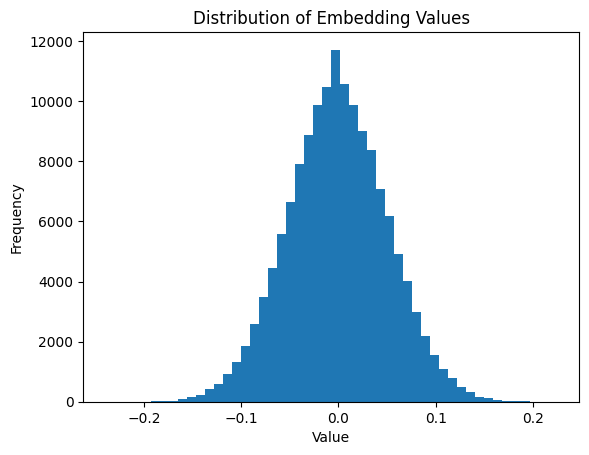

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


plt.hist(embeddings.flatten(), bins=50)
plt.title("Distribution of Embedding Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


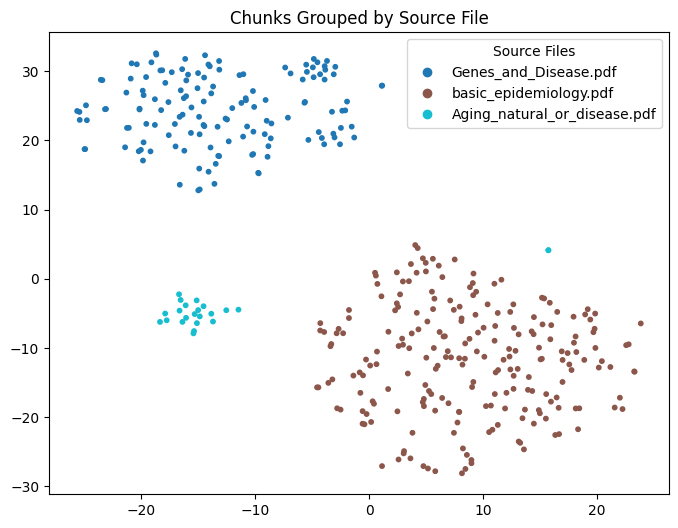

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)


pca3d = PCA(n_components=3)
reduced3d = pca3d.fit_transform(embeddings)


files = [m["source_name"] for m in metadatas]
unique_files = list(set(files))
color_map = {f: i for i, f in enumerate(unique_files)}
colors = [color_map[f] for f in files]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, cmap="tab10", s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=unique_files, title="Source Files", loc="best")
plt.title("Chunks Grouped by Source File")
plt.show()

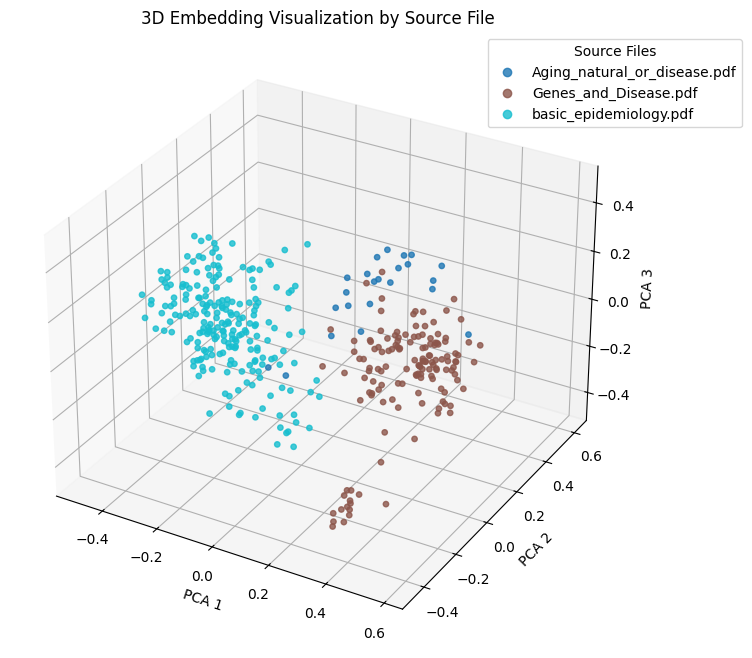

In [34]:
files = [m["source_name"] for m in metadatas]
unique_files = sorted(list(set(files))) 
color_map = {f: i for i, f in enumerate(unique_files)}
colors = [color_map[f] for f in files]



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    reduced3d[:, 0],
    reduced3d[:, 1],
    reduced3d[:, 2],
    c=colors,
    cmap='tab10', 
    s=15,
    alpha=0.8
)

ax.set_title("3D Embedding Visualization by Source File")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

legend_handles = sc.legend_elements()[0]
ax.legend(
    legend_handles,
    unique_files,
    title="Source Files",
    loc="upper right",
    bbox_to_anchor=(1.2, 1)
)

plt.show()


# Vector Store 4
### Integrate ChromaDB as the vector store

Configured ChromaDB to serve as the vector database for storing and retrieving embeddings efficiently within the RAG pipeline.


In [36]:
import os
from typing import List, Any, Optional, Dict
import chromadb
import numpy as np
from pathlib import Path

class VectorStore:
    def __init__(
        self,
        collection_name: str = "pdf_documents",
        persist_directory: str = "../data/vector_store",
        embedder_model_name: Optional[str] = "sentence-transformers/all-MiniLM-L6-v2",
    ):
        self.collection_name = collection_name
        self.persist_directory = persist_directory
        self.embedder_model_name = embedder_model_name
        self.client: Optional[chromadb.Client] = None
        self.collection = None
        self._initialize_store()

    def _initialize_store(self):
        os.makedirs(self.persist_directory, exist_ok=True)
        self.client = chromadb.PersistentClient(path=self.persist_directory)

        self.collection = self.client.get_or_create_collection(
            name=self.collection_name,
            metadata={
                "description": "documents for medical RAG project",
                "hnsw:space": "cosine",                 
                "embedder_model": self.embedder_model_name 
            },
        )
        print(f"Vector Store initialized. Collection: {self.collection_name}")
        try:
            print(f"Existing items in collection: {self.collection.count()}")
        except Exception:
            pass


    def add_documents(self, documents: List[Any], embeddings: np.ndarray):
        """
        Add or update vectors in the collection with deterministic IDs.
        - documents: List[langchain.schema.Document]
        - embeddings: np.ndarray of shape (N, D)
        """
        if documents is None or len(documents) == 0:
            print("No documents to add. Skipping.")
            return
        if embeddings is None or embeddings.shape[0] != len(documents):
            raise ValueError("Number of documents must match number of embeddings")

        print(f"Upserting {len(documents)} chunks to vector store...")

        ids: List[str] = []
        metadatas: List[Dict] = []
        documents_text: List[str] = []
        embeddings_list: List[List[float]] = []

        for i, (doc, emb) in enumerate(zip(documents, embeddings)):
            meta = dict(getattr(doc, "metadata", {}) or {})

            # Normalize/alias a few helpful fields
            src = meta.get("source_file") or meta.get("source")
            if src:
                meta["source_file"] = str(Path(src).resolve())
                meta["source_name"] = Path(meta["source_file"]).name

            meta["doc_index"] = i
            meta["content_length"] = len(getattr(doc, "page_content", "") or "")

            vec_id = make_vector_id(meta)
            ids.append(vec_id)
            metadatas.append(meta)
            documents_text.append(getattr(doc, "page_content", "") or "")
            embeddings_list.append(emb.tolist() if hasattr(emb, "tolist") else list(emb))

        # Sanity: ensure IDs are unique in this batch
        if len(ids) != len(set(ids)):
            raise ValueError("Deterministic ID collision detected. Check loader/splitter metadata (file_sha256/page/chunk_id).")

        payload = dict(
            ids=ids,
            embeddings=embeddings_list,
            metadatas=metadatas,
            documents=documents_text,
        )

        # Prefer upsert if available
        if hasattr(self.collection, "upsert"):
            self.collection.upsert(**payload)
        else:
            # Fallback for older Chroma: delete then add
            try:
                self.collection.delete(ids=ids)
            except Exception:
                pass
            self.collection.add(**payload)

        print(f"✅ Upserted {len(documents)} chunks.")
        try:
            print(f"Total items in collection: {self.collection.count()}")
        except Exception:
            pass

    def delete_by_source(self, source_path: str):
        """Delete all items from a specific absolute source path."""
        source_abs = str(Path(source_path).resolve())
        try:
            # Chroma filtering API varies by version; adapt as needed:
            self.collection.delete(where={"source_file": source_abs})
            print(f"Deleted items where source_file == {source_abs}")
        except Exception as e:
            print(f"Delete by source failed: {e}")

    def stats(self):
        try:
            print("Collection count:", self.collection.count())
        except Exception as e:
            print("Stats error:", e)


In [37]:
vs = VectorStore()

vs.add_documents(chunks, embeddings)


Vector Store initialized. Collection: pdf_documents
Existing items in collection: 0
Upserting 383 chunks to vector store...
✅ Upserted 383 chunks.
Total items in collection: 383


cheking count before and after run

In [38]:
vs.stats()  # should show 383

vs.add_documents(chunks, embeddings)  # run again

vs.stats()  # should still show 383

Collection count: 383
Upserting 383 chunks to vector store...
✅ Upserted 383 chunks.
Total items in collection: 383
Collection count: 383


retrieveing a few random items

In [39]:
res = vs.collection.get(limit=3, include=["metadatas", "documents"])
for i, (meta, doc) in enumerate(zip(res["metadatas"], res["documents"])):
    print(f"\n--- Item {i+1} ---")
    print("Source:", meta.get("source_name"))
    print("Page:", meta.get("page"))
    print("Text preview:", doc[:200])



--- Item 1 ---
Source: Aging_natural_or_disease.pdf
Page: 0
Text preview: NLM Citation: Janac S, Clarke B, Gems D. Aging: natural or disease? A view from medical textbooks. In: Vaiserman AM, editor. Anti-aging Drugs: From Basic Research to Clinical Practice [Select Chapters

--- Item 2 ---
Source: Aging_natural_or_disease.pdf
Page: 1
Text preview: survey. Perhaps if the terms used had instead been drinking and nicotine addiction, the classification would have come out the other way around? Difficulties of classification also affect aging. For e

--- Item 3 ---
Source: Aging_natural_or_disease.pdf
Page: 2
Text preview: disease states that can cause suffering and death. At present there exists some division between perspectives on aging in the medical and scientific domain. In the former the concept of normal aging i


query test

In [40]:
query_text = "What is an anti-aging intervention?"
from numpy.linalg import norm
from numpy import dot

query_emb = embedder.generate_embedding(query_text).tolist()
result = vs.collection.query(
    query_embeddings=[query_emb],
    n_results=3,
    include=["documents", "metadatas", "distances"]
)

for i, (doc, meta, dist) in enumerate(zip(result["documents"][0], result["metadatas"][0], result["distances"][0]), 1):
    print(f"\n--- Result {i} ---")
    print(f"Distance: {dist:.4f}")
    print(f"File: {meta.get('source_name')}")
    print(f"Page: {meta.get('page')}")
    print(f"Preview: {doc[:200]}")


Generated 1 embedding with dim (384,)

--- Result 1 ---
Distance: 0.2924
File: Aging_natural_or_disease.pdf
Page: 3
Preview: 1.3. What is an anti-aging intervention? If one rejects the traditional dichotomy between normal aging and aging-associated diseases, then the meaning of anti-aging becomes problematic. If the aging d

--- Result 2 ---
Distance: 0.4173
File: Aging_natural_or_disease.pdf
Page: 0
Preview: NLM Citation: Janac S, Clarke B, Gems D. Aging: natural or disease? A view from medical textbooks. In: Vaiserman AM, editor. Anti-aging Drugs: From Basic Research to Clinical Practice [Select Chapters

--- Result 3 ---
Distance: 0.4253
File: Aging_natural_or_disease.pdf
Page: 11
Preview: Figure 2. Illustrations of the distinction between normal and pathological aging from two textbooks of clinical medicine. Top, Davidson’s Principles and Practise of Medicine, ref.37 Bottom, Harrison’s


# Retriever
### Implement document retriever using cosine similarity

Configured the retriever to fetch relevant documents from the vector store based on cosine similarity, ensuring accurate and context-aware retrieval for the RAG pipeline.


In [41]:
from typing import List, Dict, Any

class Retriever:
    """Handles query-based retrieval from the vector store"""

    def __init__(self, vector_store: VectorStore, embedding_manager: Embedder):
        self.vector_store = vector_store
        self.embedding_manager = embedding_manager
        md = getattr(self.vector_store.collection, "metadata", None) or {}
        self.metric = str(md.get("hnsw:space", "cosine")).lower()

    def _to_similarity(self, distance: float) -> float:
        if self.metric == "cosine":
            return 1.0 - float(distance)
        elif self.metric in {"l2", "euclidean"}:
            return 1.0 / (1.0 + float(distance))
        elif self.metric in {"ip", "dot"}:
            return -float(distance) 
        return -float(distance)

    def retrieve(self, query: str, top_k: int = 5, score_threshold: float = 0.35) -> List[Dict[str, Any]]:
        print(f"Retrieving documents for query: '{query}'")
        print(f"Top K: {top_k}, Score threshold: {score_threshold}")

        if not query or not query.strip():
            return []

        q_emb = self.embedding_manager.generate_embedding(query)
        if hasattr(q_emb, "tolist"):
            q_emb = q_emb.tolist()

        try:
            results = self.vector_store.collection.query(
                query_embeddings=[q_emb],
                n_results=top_k,
                include=["documents", "metadatas", "distances"] 
            )

            docs_batches = results.get("documents") or []
            if not docs_batches or not docs_batches[0]:
                print("No documents found")
                return []

            documents = docs_batches[0]
            metadatas = (results.get("metadatas") or [[]])[0] or [{}] * len(documents)
            distances = (results.get("distances") or [[]])[0] or [float("inf")] * len(documents)
            
            ids       = (results.get("ids") or [[]])[0] or [None] * len(documents)

            retrieved_docs: List[Dict[str, Any]] = []
            for i, (doc_id, document, metadata, distance) in enumerate(zip(ids, documents, metadatas, distances)):
                sim = self._to_similarity(distance)
                if sim >= score_threshold:
                    retrieved_docs.append({
                        "id": doc_id,
                        "content": document,
                        "metadata": metadata or {},
                        "similarity_score": sim,
                        "distance": distance,
                        "rank": i + 1
                    })

            
            retrieved_docs.sort(key=lambda r: (-r["similarity_score"], r["rank"]))

        
            seen = set()
            unique = []
            for r in retrieved_docs:
                m = r.get("metadata") or {}
                sig = (r["content"], m.get("page"), m.get("source_file") or m.get("source"))
                if sig in seen:
                    continue
                seen.add(sig)
                unique.append(r)

            print(f"Retrieved {len(unique)} documents (after filtering & dedup)")
            return unique

        except Exception as e:
            print(f"Error during retrieval: {e}")
            return []

In [42]:
retriever = Retriever(vector_store=vs, embedding_manager=embedder)

In [44]:
hits = retriever.retrieve("What is an anti-aging intervention?", top_k=5)
for h in hits:
    m = h["metadata"]
    print(f"{h['similarity_score']:.3f} | page {m.get('page')} | {m.get('source_name')}")

Retrieving documents for query: 'What is an anti-aging intervention?'
Top K: 5, Score threshold: 0.35
Generated 1 embedding with dim (384,)
Retrieved 5 documents (after filtering & dedup)
0.708 | page 3 | Aging_natural_or_disease.pdf
0.583 | page 0 | Aging_natural_or_disease.pdf
0.575 | page 11 | Aging_natural_or_disease.pdf
0.564 | page 16 | Aging_natural_or_disease.pdf
0.560 | page 1 | Aging_natural_or_disease.pdf


In [45]:
hits

[{'id': 'f700a35f9fd7ef679f1c72a53b46a46adad1c2273dad8c7d40aeb97c543bb921:3:db4ce65576fc',
  'content': '1.3. What is an anti-aging intervention? If one rejects the traditional dichotomy between normal aging and aging-associated diseases, then the meaning of anti-aging becomes problematic. If the aging disease super-syndrome is understood as the sum of senescent pathologies and their causes, this suggests that any treatment of any senescent pathology could be understood to be an anti-aging treatment. This is problematic because treatments for existing senescent pathologies (e.g. chemotherapy for late-life cancer, or hip replacement operations) do not conform with the objective of improving late-life health by intervening in aging itself. This critical, central aim of biogerontology seems diluted or lost within such a redefinition of anti-aging. In response to this, a new definition of anti-aging has been proposed,9 to retain the utility of the term. Here, anti-aging refers specifically